In [1]:
import shutil
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
sns.set_style('ticks')
# sns.set()
sns.set_context("talk")
plt.rcParams['font.sans-serif'] = 'Times New Roman'

(Text(0.5, 0, 't (s)'),
 Text(0, 0.5, 'dsp (cm)'),
 <matplotlib.legend.Legend at 0x2aecbf58288>)

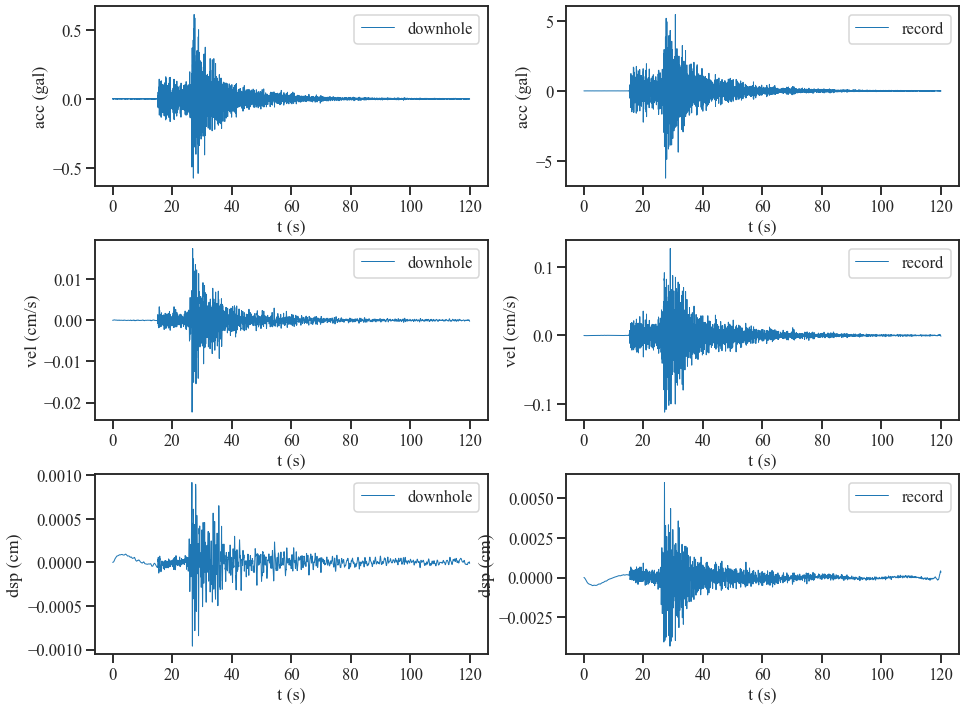

In [2]:
from cvtKiKfile import getacc, getvel_dsp, baselineCorrection
station = 'IBRH13'
filedir = 'IBRH13_data'
name = 'IBRH132008301437'
try:
    acc = getacc(os.path.join(filedir, name, name + 'EW_dh_005.acc'))
    dt = 0.005
except:
    dt = 0.01
dhacc = getacc(os.path.join(filedir, name, 'dhfilterEW.acc')) * 981
dhvel, dhdsp = getvel_dsp(dhacc, dt)
upacc = getacc(os.path.join(filedir, name, 'upfilterEW.acc')) * 981
upvel, updsp = getvel_dsp(upacc, dt)
# mdacc = getacc(os.path.join(filedir, name, 'surface.out')) / 9.81
# mdacc = mdacc - dhacc
t = np.linspace(dt, dt * len(dhacc), len(dhacc))
plt.figure(figsize=((12, 9)))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
plt.subplot(3, 2, 1)
plt.plot(t, dhacc, label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')
plt.subplot(3, 2, 2)
# plt.plot(t, mdacc, '--', label='simulate', linewidth=1)
plt.plot(t, upacc, label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (gal)'), plt.legend(loc='upper right')

plt.subplot(3, 2, 3)
plt.plot(t, dhvel, label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('vel (cm/s)'), plt.legend(loc='upper right')
plt.subplot(3, 2, 4)
# plt.plot(t, mdacc, '--', label='simulate', linewidth=1)
plt.plot(t, upvel, label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('vel (cm/s)'), plt.legend(loc='upper right')

plt.subplot(3, 2, 5)
plt.plot(t, dhdsp, label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('dsp (cm)'), plt.legend(loc='upper right')
plt.subplot(3, 2, 6)
# plt.plot(t, mdacc, '--', label='simulate', linewidth=1)
plt.plot(t, updsp, label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('dsp (cm)'), plt.legend(loc='upper right')

## 绘制数据分布图

In [3]:
msg = pd.read_excel(os.path.join(filedir, 'message.xlsx'))
msg = msg.sort_values('Record code')
msg['PGA-EW2 (g)'] *= 981
msg.rename(columns={'PGA-EW2 (g)': 'PGA (gal)'}, inplace=True)

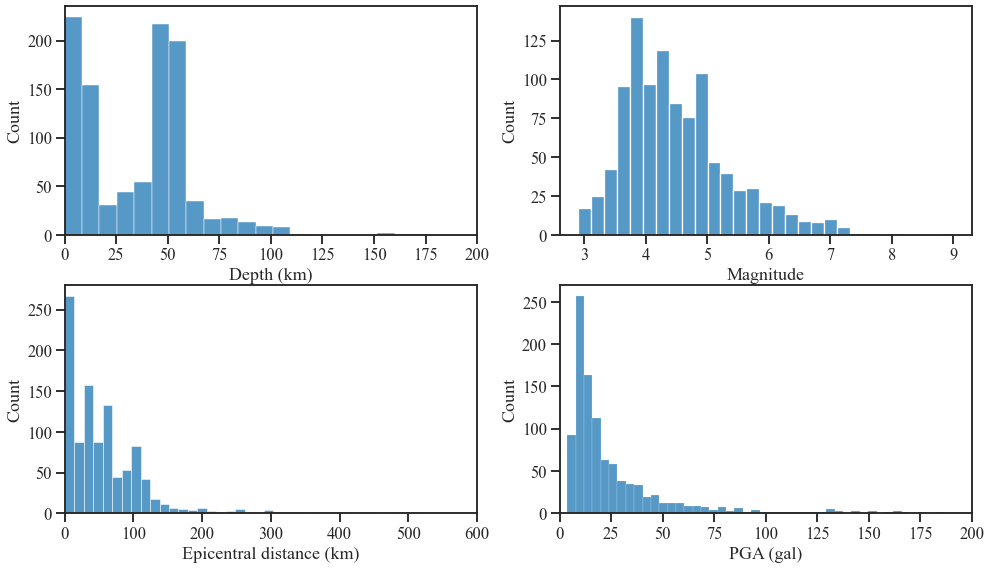

In [4]:
plt.figure(figsize=((14, 8)))
plt.subplots_adjust(left=0.08,bottom=0.1,top=0.98,right=0.98,hspace=0.22,wspace=0.2)
plt.subplot(2, 2, 1)
sns.histplot(data=msg, x='Depth (km)')
plt.xlim([0, 200])
plt.subplot(2, 2, 2)
sns.histplot(data=msg, x='Magnitude')
# plt.xlim([0, 200])
plt.subplot(2, 2, 3)
sns.histplot(data=msg, x='Epicentral distance (km)')
plt.xlim([0, 600])
plt.subplot(2, 2, 4)
sns.histplot(data=msg, x='PGA (gal)')
plt.xlim([0, 200])
plt.savefig(os.path.join(station + '_results', 'data.svg'))

## 基线调整

In [5]:
# pbar = tqdm(enumerate(msg['Record code']), total=len(msg['Record code']), desc='计算中', ncols=100)
# M = 8
# for ind, name in pbar:
#     try:
#         acc = getacc(os.path.join(filedir, name, name + 'EW_dh_005.acc'))
#         dt = 0.005
#     except:
#         dt = 0.01
#     dhacc = getacc(os.path.join(filedir, name, 'dhfilterEW.acc'))
#     upacc = getacc(os.path.join(filedir, name, 'upfilterEW.acc'))
#     dhacc_new = baselineCorrection(dhacc, dt, M)
#     upacc_new = baselineCorrection(upacc, dt, M)
#     dhfile = open(os.path.join(filedir, name, 'dhfilterEW.acc'), 'w')
#     upfile = open(os.path.join(filedir, name, 'upfilterEW.acc'), 'w')
#     for i in range(len(dhacc)):
#         dhfile.write('%7.6E\n' % dhacc_new[i])
#         upfile.write('%7.6E\n' % upacc_new[i])
#     dhfile.close()
#     upfile.close()

## 构建训练数据数组

In [6]:
dhacc_all = np.empty(shape=(0, 3000))
upacc_all = np.empty(shape=(0, 3000))
mdacc_all = np.empty(shape=(0, 3000))
dhdsp_all = np.empty(shape=(0, 3000))
updsp_all = np.empty(shape=(0, 3000))
mddsp_all = np.empty(shape=(0, 3000))
msg_all = np.empty(shape=(0, 4))
idxfile = open(os.path.join(station + '_results', 'selectevent.txt'), 'w')
goodevents = np.loadtxt(os.path.join(station + '_results', 'goodevent.txt'), dtype=str)
pbar = tqdm(enumerate(msg['Record code']), total=len(msg['Record code']), desc='计算中', ncols=100)
for ind, name in pbar:
    if msg.iloc[ind]['D95-EW1 (s)'] > 50:
        continue
    else:
        t5_dh, duration = msg.iloc[ind]['t5-EW1 (s)'], msg.iloc[ind]['D95-EW1 (s)']
        # duration = t95_dh - t5_dh
        t_start = max(t5_dh - (60 - duration) / 2, 0)
        # t_start = max(t5_dh - 5, 0)
        try:
            acc = getacc(os.path.join(filedir, name, name + 'EW_dh_005.acc'))
            dt = 0.005
        except:
            dt = 0.01
        dhacc = getacc(os.path.join(filedir, name, 'dhfilterEW.acc'))
        upacc = getacc(os.path.join(filedir, name, 'upfilterEW.acc'))
        mdacc = getacc(os.path.join(filedir, name, 'surfaceEW.out')) / 9.81
        mdacc = mdacc - dhacc
        try:
            dhacc_all = np.append(dhacc_all, dhacc[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
            upacc_all = np.append(upacc_all, upacc[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
            mdacc_all = np.append(mdacc_all, mdacc[None, int(t_start / dt) : int(t_start / dt) + int(60 / dt) : int(0.02 / dt)], axis=0)
            idxfile.write('%s\n' % name)
            data = np.array(pd.DataFrame(msg, columns=['Depth (km)', 'Magnitude', 'Epicentral distance (km)', 'PGA (gal)'], index=[ind])).ravel()
            msg_all = np.append(msg_all, data[None, :], axis=0)
        except:
            continue
np.save(station + '_dhacc.npy', dhacc_all)
np.save(station + '_upacc.npy', upacc_all)
np.save(station + '_mdacc.npy', mdacc_all)
np.save(station + '_msg.npy', msg_all)
idxfile.close()

计算中: 100%|███████████████████████████████████████████████████| 1036/1036 [00:51<00:00, 20.29it/s]


(Text(0.5, 0, 't (s)'),
 Text(0, 0.5, 'acc (g)'),
 <matplotlib.legend.Legend at 0x2aecd4b7348>)

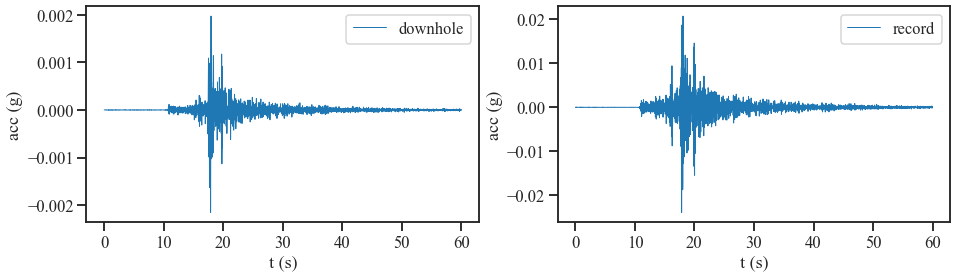

In [7]:
i = 0
t = np.linspace(0.02, 60, 3000)
plt.figure(figsize=((12, 3)))
plt.subplots_adjust(left=0,bottom=0,top=1,right=1,hspace=0.3,wspace=0.2)
plt.subplot(1, 2, 1)
plt.plot(t, dhacc_all[i, :], label='downhole', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
# plt.plot(t, mdacc_all[i, :], '--', label='simulate')
plt.plot(t, upacc_all[i, :], label='record', linewidth=1)
plt.xlabel('t (s)'), plt.ylabel('acc (g)'), plt.legend(loc='upper right')